# Basics of Mobile Robotics Project

Autumn **2025-2026**

Group n°37:
- *Daniel Alves Ataìde - 340497*
- *Rachid Kahia - 343266*
- *Nicholas Thole - 356526*

<img src="Report_Images/Christmas_Thymio.jpeg" alt="System Overview" width="70%" style="display: block; margin-left: auto; margin-right: auto;">

## Table of Contents

**1. Introduction**

**2. System Overview**

**3. Physical Environment Setup**

**4. Vision System**

**5. Global Navigation**

**6. Connecing to Thymio**

**7. Control System Overview**

**8. Kalman Filter**

**9. Motion Controller**

**10. Local Navigation**

**11. Kidnapping Resilience**

**12. Dead Reckoning**

**13. Demo Video**

**14. Conclusion**

**Bibliography**

## Introduction

### Project Objective

The objective of this project is to develop an autonomous mobile robot capable of navigating from a starting position to a goal position while avoiding obstacles in a controlled environment. The robot used is a Thymio II, equipped with infrared proximity sensors and controlled via the TDM protocol. A camera positioned above the workspace provides real-time visual feedback, enabling the robot to localize itself and detect obstacles.

The system handles two types of obstacles:

1. **Static obstacles (camera-detected)**: These are known obstacles placed in the environment that are detected by the overhead camera through color filtering. They are used during the global path planning phase to compute collision-free trajectories. These obstacles are not detectable by the robot's onboard sensors.

2. **Dynamic/unexpected obstacles (sensor-detected)**: These are obstacles that may appear during navigation and are detected by the Thymio's infrared proximity sensors. The robot must reactively avoid these obstacles using local navigation strategies while maintaining progress toward the goal.

In addition to basic navigation, the system must demonstrate robustness through two additional objectives:

1. **Vision-loss resilience**: If the camera is blocked or vision is temporarily lost, the robot must continue navigating toward the goal using dead reckoning based on wheel odometry. While precision will be reduced without visual feedback, the Kalman filter's prediction step allows the robot to maintain an estimated pose and continue making progress.

2. **Kidnapping recovery**: If the robot is suddenly moved to a new position (the "kidnapping problem"), the system must detect this significant change in pose, recompute the optimal path from the new location to the goal, and resume navigation seamlessly.

## System Overview and Architecture

<img src="Report_Images/BOMR_Project_Flowchart.png" alt="System Overview" width="70%" style="display: block; margin-left: auto; margin-right: auto;">

The navigation system follows a sequential pipeline that combines global planning with real-time feedback control:

1. **Vision System** creates a map of the environment from the camera by detecting obstacles and identifying potential waypoints positioned safely away from obstacle edges where the robot can pass. This environmental map is passed to the path planner. The camera also detects the robot's position and orientation (pose) and the goal position.

2. **Path Planner (Global Navigation)** receives the map and computes the shortest collision-free path from the robot's starting position to the goal using the A* algorithm on a visibility graph. The result is a sequence of waypoint coordinates that define the optimal trajectory.

3. **Kalman Filter** provides accurate state estimation by fusing two sources of information: the noisy pose measurements from the camera and the imperfect position estimates derived from wheel odometry. This sensor fusion produces a filtered pose estimate that combines the strengths of both sensors while mitigating their individual weaknesses.

4. **Motion Controller** receives the waypoint sequence from the path planner and the current filtered pose from the Kalman filter. It computes appropriate left and right wheel speeds to navigate the robot toward the next waypoint in the sequence.

5. **Local Navigation** operates in parallel with global navigation. The Thymio continuously sends its infrared proximity sensor data to the local avoidance system, which detects unexpected obstacles not visible to the camera. When obstacles are detected, the local navigation modulates the controller's wheel speeds to reactively avoid collisions while maintaining progress toward the goal.

This architecture ensures robust navigation by combining optimal global planning with reactive local obstacle avoidance.



### System Components

Each of the main components described above is implemented as a dedicated Python class, encapsulating all the functions necessary to fulfill its specific tasks. Note that the **Local Navigation** function is integrated within the **Motion Controller** class, as they work closely together to control the robot's movement. Additionally, a **Visualizer** class provides real-time visualization on the computer screen, displaying the camera feed with overlays showing detected obstacles, robot position, planned path, and sensor readings.

The system also includes a [`utils.py`](utils.py) module that contains important constants used throughout the codebase, such as the Thymio's physical dimensions (wheel base width, wheel radius).$^{[1.1]}$

### Running the Project

To run the complete navigation system, execute the [`main.py`](main.py) script. This script contains everything needed to initialize all components, establish communication with the Thymio, start the camera feed, and execute the full navigation pipeline from start to goal. Please be sure your Thymio is unlocked, otherwise you will get a "node_lock" error and the program will not be able to connect to the Thymio.

**Note:** The entire project was designed and tested exclusively on macOS. While the core functionality should work on Windows, minor adjustments may be required to connect to the Thymio robot, for camera access, file paths, or system-specific dependencies.


### Team Contributions

The project was developed collaboratively, with each team member taking primary responsibility for specific components:

- **Daniel Alves Ataìde**: Implemented the local navigation system using the ANN approach. Daniel also created the overall code architecture and integrated all components, ensuring that the vision system, path planner, controller, and filters worked together seamlessly.

- **Rachid Kahia**: Led the development of the vision system with contributions from the entire team, and developed the Kalman Filter.

- **Nicholas Thole**: Designed and implemented the global path planning algorithm and the motion controller.

This report was primarily written by Rachid and Nicholas.

---

**Note on Citations:** Throughout this report, sources are cited using bracketed numbers (e.g. $^{[1.1]}$). All referenced sources can be found in the Bibliography section at the end of the report.

*To be able run the snippets of code in this notebook, make sure to run the following cell with all the necessary imports.*

In [3]:
# Standard library imports
import asyncio
import time

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tdmclient import ClientAsync, aw
from cv2 import aruco
from IPython.display import Video


# Project module imports
from utils import WHEEL_RADIUS_MM, THYMIO_WIDTH_MM, THYMIO2MMS
from vision_system import VisionSystem
from kalman_filter import KalmanFilter
from path_planner import PathPlanner
from motion_controller import MotionController, ThymioConnection
from visualizer import Visualizer

## Physical Environment Setup

<img src="Report_Images/Setup.PNG" alt="System Overview" width="50%" style="display: block; margin-left: auto; margin-right: auto;" style="display: block; margin-left: auto; margin-right: auto;">

The navigation experiments were conducted in a controlled workspace designed to test both camera-based and sensor-based obstacle detection capabilities.

**Workspace Surface**: The Thymio robot operated on a large white sheet of paper, which provided a uniform, high-contrast background that simplified computer vision processing and clearly defined the navigable area.

**Static Obstacles (Camera-Detected)**: Rectangular blue paper sheets were placed on the white surface to serve as obstacles for the path planning system. Blue was specifically chosen as the obstacle color because it provides strong visual contrast against both the white background and the black-and-white markers used for localization. This color distinction enables the vision system to reliably segment obstacles from other elements in the scene without confusion.

**Dynamic Obstacles (Sensor-Detected)**: We introduced a cylindrical obstacle with a 6 cm diameter, which was selected for its predominantly white surface, which makes it highly reflective to the Thymio's infrared proximity sensors, ensuring reliable detection at close range.

**Localization Markers**: To enable precise localization and define the workspace boundaries, we positioned ArUco markers at strategic locations throughout the environment.

### ArUco Markers

**ArUco markers** are square fiducial markers designed for robust camera pose estimation and object tracking in computer vision applications. Each marker consists of a unique black-and-white pattern enclosed in a black border, making it easily distinguishable from the background and other markers. The markers belong to predefined dictionaries (we used the first 6 markers of the `DICT_4X4_50`, which contains 50 unique 4×4 bit patterns), and OpenCV provides efficient detection algorithms that can identify multiple markers simultaneously in a single image.

ArUco markers offer several key advantages for robotics applications:
- **Precise localization**: The marker's corners can be detected with sub-pixel accuracy, enabling accurate position and orientation estimation
- **Unique identification**: Each marker has a distinct ID, allowing the system to differentiate between multiple markers in the scene
- **Robustness**: The black border and error correction capabilities make them detectable even under varying lighting conditions and partial occlusions


<img src="Report_Images/ArUco_markers_expl.jpeg" alt="ArUco Markers" width="50%" style="display: block; margin-left: auto; margin-right: auto;">

*Example of ArUco markers of different bit sizes* $^{[2.1]}$

## Convention

<img src="Report_Images/Convention.PNG" alt="ArUco Markers" width="45%" style="display: block; margin-left: auto; margin-right: auto;">

## Vision System

A significant part of this project relies on computer vision. We made extensive use of the *OpenCV* library to implement the image-processing pipeline that enables the robot to interpret its environment. All vision-related functionalities are organized within a dedicated [`VisionSystem`](vision_system.py) class, implemented in the file *vision_system.py*.

### Camera Hardware

At the beginning of the project, we planned to use the provided Aukey webcam. However, once we started coding and sharing our programs, we quickly ran into practical issues since we only had a single webcam to share among the three team members. Since we all work on Mac, we found a more efficient solution: using our iPhones as cameras. Thanks to Apple's Continuity Camera feature, each of us could easily use our iPhone as an external webcam for our MacBook. This allowed everyone to run and test the vision code independently without relying on a single shared device.

### Vision System Initialization
We began by implementing the `VisionSystem` constructor, which initializes all required variables. It opens the camera stream using OpenCV’s `VideoCapture` and loads the ArUco dictionary.

In [4]:
class VisionSystem:

    def __init__(self, camera_id=0, aruco_dict_type=aruco.DICT_4X4_50):
        self.cap = cv2.VideoCapture(camera_id)
        self.aruco_dict = aruco.getPredefinedDictionary(aruco_dict_type)
        self.aruco_params = aruco.DetectorParameters()

        # Initialize variables
        self.detected_markers = {}
        self.corners = None  # [(x1, y1), ...]
        self.transform_matrix = None
        self.mm2px = None
        self.map_size = (900, 600)
        self.goal_position = None  # (x, y)

### Camera Setup and Perspective Correction

The camera was mounted above the workspace with the goal of achieving a perfectly vertical, top-down view of the environment. However, achieving exactly 90 degrees is practically impossible due to physical mounting constraints and alignment limitations—there will always be a slight angular offset. This angled view causes perspective distortion: objects closer to the camera appear larger than those farther away, and parallel lines in the real world appear to converge in the image.

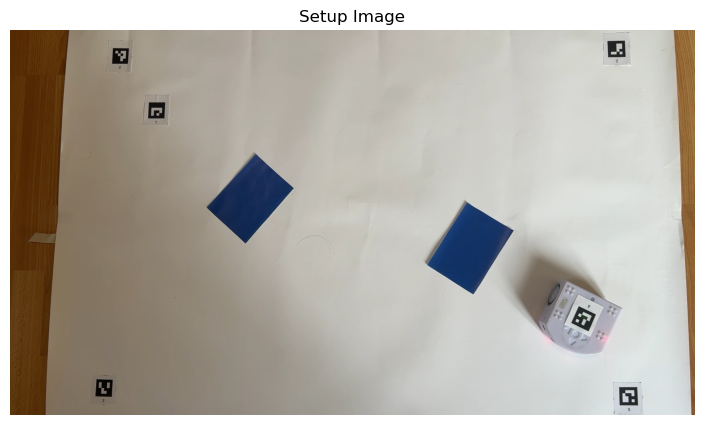

In [5]:
image = cv2.imread("Report_Images/Raw_Frame.jpg")

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Setup Image")
plt.show()

### Calibration Process

The calibration system automatically detects and processes ArUco markers to establish the reference frame for navigation. We use six markers in total throughout the project:
- **Four corner markers** (IDs 0, 2, 3, 5) define the rectangular workspace boundaries
- **One goal marker** (ID 1) specifies the target destination
- **One robot marker** (ID 4) is attached to the top of the Thymio for pose detection

The calibration is handled by the [`calibrate`](vision_system.py) method, which continuously captures camera frames and searches for the corner and goal markers (the robot marker is not required during calibration). To ensure robustness against temporary detection failures or false positives, the system requires **five markers (four corners + goal)** to remain **stable for 15 consecutive frames** before proceeding. During this stabilization period, the live camera feed displays:
- Green circles marking each detected corner marker
- Green lines connecting the corners to visualize the rectangular map region
- A magenta circle marking the goal position
- A stability progress bar indicating calibration completion percentage

As can be seen in our demo video, once the markers remain stable, the system automatically completes calibration by:

1. **Ordering corner markers**: The four corner positions are sorted into a consistent sequence (top-left, top-right, bottom-right, bottom-left) using the [`_order_points`](vision_system.py) method, which analyzes their spatial relationships
   
2. **Computing the perspective transform**: A homography matrix is calculated using OpenCV's `getPerspectiveTransform`, which maps the quadrilateral defined by the detected corners to a perfect rectangle of specified dimensions (default 900×600 pixels). This aspect ratio must match the physical workspace dimensions to preserve geometric accuracy—our workspace measures 900mm × 600mm, giving the same 3:2 aspect ratio.
   
3. **Establishing the coordinate system**: The transformation matrix enables [`get_transform_frame`](vision_system.py) to warp each subsequent camera frame into a geometrically corrected top-down view where:
   - The four corners map to the exact rectangle corners in pixel space
   - Parallel lines in the real world remain parallel in the image
   - Euclidean distances are preserved and can be accurately measured
   
4. **Transforming the goal position**: The goal marker's camera coordinates are transformed into the new reference frame using `cv2.perspectiveTransform`, storing the result as [`goal_position`](vision_system.py) for use in path planning

The calibration completes automatically and the navigation loop begins with a properly aligned coordinate system.

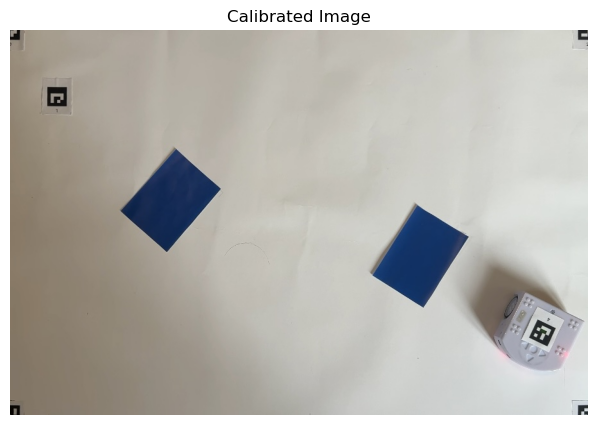

In [13]:
image = cv2.imread("Report_Images/Calibrated_Frame.jpg")

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Calibrated Image")
plt.show()

### Converting Real-World Distances (mm) to Pixels

During calibration, the physical height of the map is known:

$$H_{\text{real}}  \text{[mm] = 655 [mm]} $$

and the corresponding height in the transformed top-down image is fixed:

$$H_{\text{px}}  \text{[pixels] = 600 [pixels]} $$

The conversion factor from millimeters to pixels is therefore:
$$ \text{mm2px} = \frac{H_{\text{px}}}{H_{\text{real}}} \approx 0.916$$

This scalar tells us how many pixels correspond to one millimeter in the real world.  
It allows converting any real-world measurement $d_{\text{mm}}$ into pixel units:
$$ d_{\text{px}} = d_{\text{mm}} \cdot \text{mm2px} $$


### Robot pose detection

We use the function `detect_raw_robot_pose` to detect the robot pose, and get its orientation. To do this, we use trigonometry. Here is the thought process behind the robot orientation estimation from the aruco marker :

In [14]:
def detect_robot_raw_pose(self, frame):

    marker_centers = self._detect_marker_centers(frame, target_ids={4})


    if 4 not in marker_centers:
        return None

    robot_data = self.detected_markers[4]
    corners = robot_data['corners']   # Orientation, corners are: TL, TR, BR, BL

    # Orientation from top edge of marker
    top_center = (corners[0] + corners[1]) / 2
    center = np.array(robot_data['center'])

    dx = top_center[0] - center[0]
    dy = top_center[1] - center[1]
    theta = np.arctan2(dy, dx)   # Compute angle in radians

    return np.array([center[0], center[1], theta])

<img src="Report_Images/Robot_Pose.PNG" alt="ArUco Markers" width="45%" style="display: block; margin-left: auto; margin-right: auto;">

To compute the orientation angle θ, we:

1. Compute the top edge midpoint: average of corners[0] ('top left' -> TL) and corners[1] ('top right' -> TR)
2. Find the marker center: average of all four corners
3. Compute the direction vector from center to top edge midpoint
4. Extract the angle using θ = arctan2(dy, dx)

This gives the orientation of the marker's "up" direction in the camera frame. By mounting the marker with its top edge aligned with the robot's forward direction, θ directly represents the robot's heading.


### Obstacle Detection and Image Processing

To detect obstacles, we initially considered using black objects combined with classical edge detection. However, the presence of other dark elements in the scene, such as the ArUco markers themselves and parts of the Thymio robot, made this approach unreliable and prone to false detections.

We therefore switched to using **blue-colored obstacles** and applied color filtering in HSV color space to extract blue regions from the image. This method proved highly effective: the distinct color separated obstacles cleanly from the environment, and combined with morphological operations and contour detection, it became the foundation of our final obstacle detection pipeline.

**Pipeline for obstacle detection and Image processing :**
1. Obtain the cropped and Perspective transformed Image from the calibration.

2. Use that Image, and convert it to HSV.

3. Generate a binary mask that filters the non-blue colors, using predefined thresholds in the HSV Image.

4. Perform morphological operations on the mask to clean and improve the shapes :
- We use `MORPH_OPEN` (erosion followed by dilation), to remove small white noise.
- and `MORPH_CLOSE` (dilation followed by erosion), to fill small black holes and to connect nearby white regions.

5. Apply a gaussian blur as a pre-processing step, before performing Canny edge detection.

6. Dilate the edges to make theam more visible.

7. Scale the edges and detect contours of polygonal obstacles.

8. Draw the polygonal shapes, as well as their vertices (red points) on the displayed image.

To detect obstacles, we first capture frames from the camera and apply a color filter using OpenCV’s `inRange` function (with a lower and upper threshold for blue) on the HSV representation of the image. This produces a mask, isolating only the blue pixels corresponding to our obstacles.

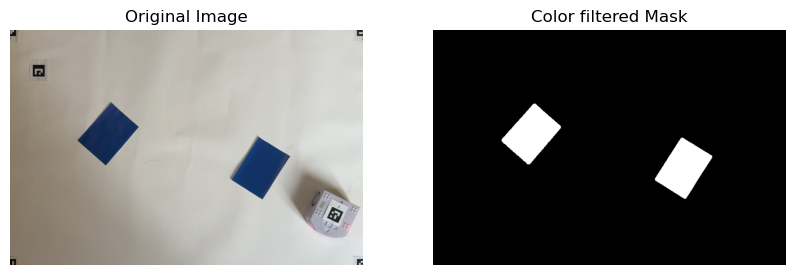

In [15]:
from code_for_report import filter_color

mask = filter_color(image)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Color filtered Mask")
plt.imshow(mask, cmap="gray")
plt.axis('off')

plt.show()

Next, we apply a 3×3 Gaussian blur on the mask to reduce noise, followed by Canny edge detection to extract the contours of the polygonal obstacles.

<Figure size 1000x500 with 0 Axes>

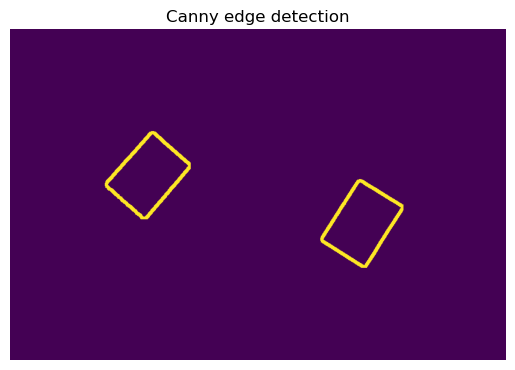

In [16]:
from code_for_report import process_image

edges = process_image(mask)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.figure()
plt.imshow(edges, cmap='viridis')
plt.axis('off')
plt.title("Canny edge detection")
plt.show()

With this edge image, we scale each obstacle’s contour using our custom `scale_contour` function, and then use the very powerful OpenCV functions `findContours `and `approxPolyDP` in our `detect_contours` function to recover the vertices of the scaled shapes. To avoid false positives, we restrict the obstacles to polygons with exactly four vertices.

Finally, we draw the scaled polygons in red, along with red circles indicating each detected vertex, on the output frame.


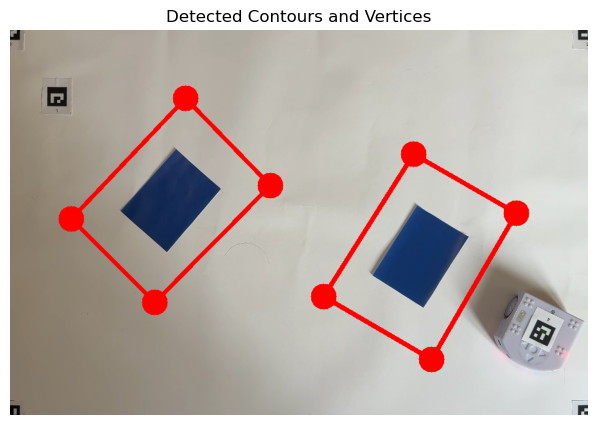

In [17]:
from code_for_report import detect_contours, draw_contours

scaled_contours, all_vertices = detect_contours(edges)
output_image = draw_contours(image, scaled_contours, all_vertices)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Detected Contours and Vertices")
plt.show()

### The Visualizer Class

We were required to have real-time visualizations to illustrate the mapping, path planning, navigation, filtering, etc. In order to do that we created a class called "Visualizer" that will be called only once at the very end of each navigation loop. This allows us to separate the functional code from the visual code, allowing to quickly know in which sections an unpredicted bug may be and keep everything related to the visuals in the same file. To correctly use this class, call the function visualizer.update() providing the correct variables, everything will display itself correctly after that.

In [ ]:
visualizer.update(
                frame=frame,
                obstacles=obstacles,
                robot_pos=robot_pose,
                path=path,
                current_waypoint_idx=waypoint_idx if path else 0,
                sensor_data=sensor_data,
                goal_pos=vision.goal_position,
                info_dict=info,
                kalman_state=kalman.state,
                kalman_covariance=kalman.P
            )

## Global Navigation

The global navigation system computes an optimal collision-free path from the robot's starting position to the goal before movement begins. It uses the map of static obstacles provided by the vision system to build a **visibility graph**: a network where nodes represent potential waypoints (vertices of the expanded obstacles, start, and goal), and edges connect pairs of nodes that have an unobstructed line of sight between them. The A* algorithm then searches this graph to find the shortest path, resulting in a sequence of waypoints the robot should follow.

### Why Visibility Graphs Over Grid-Based Methods?

An alternative approach to path planning would be to discretize the workspace into a uniform grid and use grid-based search algorithms (such as A*) to find paths through obstacle-free cells. While this method can potentially yield shorter paths by allowing in theory the robot to follow grid diagonals and explore more trajectory options, we deliberately chose the visibility graph approach for several practical reasons.

 First, **implementation complexity**: grid-based planning would still require converting the resulting grid path into waypoints for our controller to follow, essentially duplicating the waypoint-following logic we already implemented. The visibility graph naturally produces waypoints at obstacle vertices, which integrate seamlessly with our Astolfi-based waypoint controller without requiring additional path smoothing or waypoint extraction steps.
 
 Second, **computational efficiency**: in environments with few obstacles like ours (two quadrilaterals), the visibility graph contains only ~10 nodes, making path computation extremely fast. A grid-based approach with sufficient resolution for accurate navigation (e.g., 5-10 pixel grid cells) would create hundreds of nodes, significantly increasing search time without meaningful benefit. 
 
 Third, **obstacle-aware waypoints**: the visibility graph vertices lie precisely at obstacle corners—locations the robot *must* pass near when navigating around obstacles. This ensures our waypoints are geometrically relevant to the environment structure. 

### Visibility Graph Construction

Before constructing the visibility graph, the system first assembles a complete list of all nodes (waypoints) that will form the vertices of the graph. This node list is created by combining:

1. **Start position**: The robot's current pose (index 0 in the node list)
2. **Goal position**: The target destination (index 1 in the node list)  
3. **Expanded obstacle vertices**: All corner points of the obstacles after they have been expanded by the robot's radius to account for its physical size

This node assembly happens in the [`compute_path`](path_planner.py) method before calling the visibility graph builder:

```python
nodes = [np.array(start), np.array(goal)]
for poly in obstacles:
    for v in poly:
        nodes.append(np.array(v))
```

By placing start and goal at indices 0 and 1 respectively, the pathfinding algorithm knows exactly which nodes represent the start and end points without needing to search through the entire list.

Once the waypoint nodes are established, the system constructs a **visibility graph** that defines which waypoints can be directly connected by straight-line paths.

The visibility graph is built by the [`build_visibility_graph`](path_planner.py) method, which operates as follows:

1. **Graph Initialization**: An empty adjacency list is created for each node in the node list.

2. **Pairwise Visibility Testing**: For every unique pair of nodes, the system checks if a straight line between them is obstacle-free using the [`_is_visible`](path_planner.py) method. This visibility check includes:
   - **Special case handling**: If both nodes are vertices of the same polygon, the connection is only allowed if they are adjacent vertices (connected by an edge). This prevents diagonal connections that would cut through the obstacle's interior.
   - **Edge intersection testing**: The line segment is tested against all obstacle edges to ensure it doesn't intersect with any boundaries. The intersection test uses an **orientation-based geometric algorithm**$^{[3.1]}$ that works as follows:
     
     To determine if line segment $p_1p_2$ intersects with obstacle edge $q_1q_2$, we compute the **orientation** of four triplets of points:
     - Orientation of $(p_1, p_2, q_1)$: Is $q_1$ to the left, right, or on the line $p_1p_2$?
     - Orientation of $(p_1, p_2, q_2)$: Is $q_2$ to the left, right, or on the line $p_1p_2$?
     - Orientation of $(q_1, q_2, p_1)$: Is $p_1$ to the left, right, or on the line $q_1q_2$?
     - Orientation of $(q_1, q_2, p_2)$: Is $p_2$ to the left, right, or on the line $q_1q_2$?
     
     The orientation is computed using the **cross product** of vectors: for points $(a, b, c)$, the orientation is determined by the sign of $(b_x - a_x)(c_y - a_y) - (b_y - a_y)(c_x - a_x)$. This value is positive if $c$ is to the left of line $\overrightarrow{ab}$, negative if to the right, and zero if collinear.
     
     **Intersection occurs** when the two endpoints of each segment lie on **opposite sides** of the other segment's line. Specifically, if $(p_1, p_2, q_1)$ and $(p_1, p_2, q_2)$ have different orientations, **and** $(q_1, q_2, p_1)$ and $(q_1, q_2, p_2)$ have different orientations, then the segments intersect. Special handling is required for collinear cases where points lie on the same line.

3. **Edge Creation**: If two nodes are mutually visible (pass both checks above), an edge is added to the graph **in both directions** with a weight equal to the Euclidean distance between them.

The implementation in [`path_planner.py`](path_planner.py) demonstrates this process:

In [33]:
# Coordinates from the setup as seen in previous images
goal = np.array([72.80178833007812, 103.4753646850586])
obstacles = [np.array([[627, 193], [489, 415], [659, 511], [789, 283]]), 
             np.array([[273, 105], [93, 293], [227, 425], [405, 241]])]
start = np.array([823.25, 480.0])

# Build nodes list
nodes = [start, goal]
for poly in obstacles:
    for v in poly:
        nodes.append(np.array(v))

# Create planner and build visibility graph
planner = PathPlanner()
planner.graph = planner._build_visibility_graph(nodes, obstacles)

# Print the visibility graph
print("Visibility Graph (adjacency list):")
print("Format: node_index: [(connected_node_index, distance), ...]")
print()
for node_idx, connections in planner.graph.items():
    print(f"Node {node_idx}: {connections}")

Visibility Graph (adjacency list):
Format: node_index: [(connected_node_index, distance), ...]

Node 0: [(4, np.float64(167.14982052039423)), (5, np.float64(199.95515122146767))]
Node 1: [(6, np.float64(200.20401711423878)), (7, np.float64(190.59788861874756))]
Node 2: [(3, np.float64(261.3962509295036)), (5, np.float64(185.32134253776601)), (6, np.float64(364.7739025752802)), (8, np.float64(462.4110725317896)), (9, np.float64(227.1299187689724))]
Node 3: [(2, np.float64(261.3962509295036)), (4, np.float64(195.2331938989884)), (8, np.float64(262.1907702418222)), (9, np.float64(193.21490625725542))]
Node 4: [(0, np.float64(167.14982052039423)), (3, np.float64(195.2331938989884)), (5, np.float64(262.4576156258378)), (8, np.float64(440.477014156244))]
Node 5: [(0, np.float64(199.95515122146767)), (2, np.float64(185.32134253776601)), (4, np.float64(262.4576156258378))]
Node 6: [(1, np.float64(200.20401711423878)), (2, np.float64(364.7739025752802)), (7, np.float64(260.27677575995904)), (9,

ADD A BIT OF CODE ABOVE TO BE ABLE TO RUN THIS SUCH THAT IT PRODUCES A VISIBILITY GRAPH - Call the functions from path planner

### Path Planning Algorithm

We implemented the **A\* (A-star) algorithm** to find the shortest path through the environment. A\* was chosen over simpler alternatives like Dijkstra's algorithm because it uses a **heuristic** function—an estimated cost that predicts the remaining distance from any node to the goal—to guide the search more efficiently. While Dijkstra explores nodes uniformly in all directions, A\* prioritizes nodes that appear closer to the goal based on this heuristic.$^{[3.2]}$ 

In our implementation, we use the **Euclidean distance** (straight-line distance) as the heuristic: $h(n) = \sqrt{(x_n - x_{goal})^2 + (y_n - y_{goal})^2}$. This heuristic is admissible because it never overestimates the actual shortest path distance, which is a key requirement for A\* to guarantee optimal solutions $^{[3.3]}$. This targeted exploration reduces computation time—a critical advantage for real-time robotics applications where the robot may need to replan paths quickly, such as after kidnapping detection. 

In our specific use case with only two quadrilateral obstacles (resulting in approximately 10 nodes total including start and goal), the computational difference between A\* and Dijkstra's algorithm is negligible. However, A\* was chosen for its scalability and to demonstrate best practices for path planning in more complex environments with numerous obstacles.

The A\* algorithm is implemented in the [`_a_star`](path_planner.py) method within the `PathPlanner` class, which searches the visibility graph using a priority queue to efficiently explore nodes in order of their estimated total cost to the goal.

ADD CODE HERE TO SHOW THE SHORTEST PATH WHICH IS CALCULATED

### Output
The result of the path planning is a sequence of waypoint coordinates $[(x₁, y₁), (x₂, y₂), ..., (xₙ, yₙ)]$ that defines the optimal trajectory from start to goal. This path is then passed to the motion controller, which navigates the robot through each waypoint in sequence while the Kalman filter provides accurate pose estimates.

## Connecting to Thymio

### Prerequisites

Before establishing a connection in code, you must prepare the Thymio for wireless communication:

1. **Launch Thymio Suite**: Open the Thymio Suite application on your computer
2. **Detect the Robot**: Wait for your Thymio to be detected via the wireless dongle
3. **Open Aseba Studio**: Click to open Aseba Studio from Thymio Suite
4. **Unlock the Robot**: Click the unlock icon in Aseba Studio to make the robot available for external connections

This unlocking step is crucial - without it, the TDM client cannot establish a connection to the robot.

### Connection Implementation

We connect to the Thymio wirelessly using the **TDM (Thymio Device Manager) protocol** through the `tdmclient` Python library. The connection is managed by a custom [`ThymioConnection`](motion_controller.py) context manager class that ensures proper resource handling:


In [ ]:
class ThymioConnection:
    """Context manager for safe Thymio connection handling."""

    def __init__(self):
        """Initialize connection manager."""
        self.client = None
        self.node = None

    def __enter__(self):
        """
        Establish connection and lock Thymio.

        Returns:
            tuple: (client, node) for Thymio communication
        """
        self.client = ClientAsync()
        self.node = aw(self.client.wait_for_node())
        aw(self.node.lock())
        return self.client, self.node

    def __exit__(self, exc_type, exc_val, exc_tb):
        """
        Stop motors and release Thymio connection.

        Args:
            exc_type: Exception type if error occurred
            exc_val: Exception value
            exc_tb: Exception traceback

        Returns:
            bool: False to propagate exceptions
        """
        if self.node is not None:
            try:
                aw(self.node.set_variables({
                    "motor.left.target": [0],
                    "motor.right.target": [0],
                }))
                aw(self.node.stop())
                aw(self.node.unlock())
            except Exception:
                pass

        if self.client is not None:
            try:
                self.client.close()
            except Exception:
                pass

        return False

The connection is established at the start of the navigation loop in [`main.py`](main.py):

## Control System Overview (à voir si on garde)


<img src="Report_Images/Control_System.PNG" alt="ArUco Markers" width="70%" style="display: block; margin-left: auto; margin-right: auto;">

## Kalman Filter
### Why do we need a Kalman filter
In this project, we need an accurate estimate of the robot’s pose throughout its motion. Using only the top camera would give us a rough estimate of the Thymio’s position, but it is often noisy and prone to errors, which can lead to unstable or undesired behavior. To address this, we integrate a Kalman filter that fuses information from both the camera and the robot’s odometry. This combination provides a smoothed, robust, and reliable estimate of the robot’s position.

Beyond improving accuracy, the Kalman filter also allows us to predict future states using a motion model. This becomes essential when visual tracking is temporarily lost for example, if the camera view is obstructed or if the robot is moved unexpectedly (“kidnapped”). In such cases, the filter maintains a belief about the robot’s pose, with an uncertainty that naturally increases over time.

### We implmented an Extended Kalman filter - Why ?
We chose to implement an Extended Kalman Filter (EKF) because the Thymio’s motion model is nonlinear. While a standard Kalman filter applies only to linear systems, the EKF linearizes the nonlinear dynamics around the current state estimate, making it suitable for mobile robots like ours. This is consistent with the EKF formulation introduced in the MICRO-452 course.

Given the scope of the project, we implemented a simple version of the EKF. We initially looked at general explanations such as the Kalman Filter Wikipedia page, but the theory was too broad for our needs. We then asked ChatGPT for a concise overview and a pseudocode outline, which helped us structure our implementation.


In our EKF, the state vector is very basic and consists of only three variables:

$$
\mathbf{x} = 
\begin{bmatrix}
x \\
y \\
\theta
\end{bmatrix}
$$

### Main EKF Variables

- **State vector:**  $\mathbf{x} = [x, y, \theta]^\top$

- **Motion model:**  $\mathbf{g}(\mathbf{x})$

- **Measurement model:**  $\mathbf{h}(\mathbf{x})$

- **Covariance matrix:**  $\mathbf{P}$

- **Jacobians:**  $\mathbf{G} = \frac{\partial \mathbf{g}}{\partial \mathbf{x}}$, $\mathbf{H} = \frac{\partial \mathbf{h}}{\partial \mathbf{x}}$

Now, let's get into more details for these variables :

### Measurement Model

- $\mathbf{z}$ : measure given by the external sensor (camera) with noise, error and fluctuations

$$
\mathbf{z} = 
\begin{bmatrix}
x_{\text{cam}} \\
y_{\text{cam}} \\
\theta_{\text{cam}}
\end{bmatrix}
$$

- $\mathbf{h}(\mathbf{x})$ : Measurement model - Since the sensor observes the pose directly, it is:

$$
\mathbf{h}(\mathbf{x}) =
\begin{bmatrix}
x \\
y \\
\theta
\end{bmatrix}
$$

- The **innovation** $\mathbf{i}_k$ is:

$$
\mathbf{i}_k = \mathbf{z}_k - \mathbf{h}(\hat{\mathbf{x}}_{k|k-1})
$$

- $\mathbf{H}$ : The Jacobian of the measurement model is simply:

$$
\mathbf{H} =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
= \mathbf{I}_3
$$


### Motion Model

We define differential-drive kinematics with wheel speeds $\mathbf{v_L}$ and $\mathbf{v_R}$, wheel separation $\mathbf{L}$, and timestep $\Delta \mathbf{t}$.

- Linear and angular velocities:

$$
\begin{cases}
v = \frac{v_L + v_R}{2}, \\
\omega = \frac{v_L - v_R}{L}
\end{cases}
$$

- $\mathbf{g}(\mathbf{x})$ : The predicted state according to the motion model is:

$$
\mathbf{g}(\mathbf{x}) =
\begin{bmatrix}
x + v\Delta t \cos\theta \\
y + v\Delta t \sin\theta \\
\theta + \omega \Delta t
\end{bmatrix}
$$

- $\mathbf{G}$ : the Jacobian of the motion model is :

$$
\mathbf{G} =
\frac{\partial \mathbf{g}}{\partial \mathbf{x}} =
\begin{bmatrix}
1 & 0 & -v \Delta t \sin\theta \\
0 & 1 & \;\;v \Delta t \cos\theta \\
0 & 0 & 1
\end{bmatrix}
$$

### Covariance Matrix (**P**) :

It represents the uncertainty in the estimated state and its correlations.

$$
\mathbf{P} =
\begin{bmatrix}
\sigma_x^2 & \sigma_{xy} & \sigma_{x\theta} \\
\sigma_{yx} & \sigma_y^2 & \sigma_{y\theta} \\
\sigma_{\theta x} & \sigma_{\theta y} & \sigma_\theta^2
\end{bmatrix}
$$

## EKF Algorithm
The formulas of the predict and update functions of the EKF algorithm were deducted from Wikipedia [Link Text](https:// en.wikipedia.org/wiki/Extended_Kalman_filter) :

1. **Predict**

- State prediction: 
$\hat{\mathbf{x}}_{k|k-1} = \mathbf{g}(\hat{\mathbf{x}}_{k-1})$

- Covariance prediction: 
$\mathbf{P}_{k|k-1} = \mathbf{G}_k \, \mathbf{P}_{k-1} \, \mathbf{G}_k^\top + \mathbf{Q}$


2. **Update**

- Innovation: $\mathbf{i}_k = \mathbf{z}_k - \mathbf{h}(\hat{\mathbf{x}}_{k|k-1})$

- Innovation covariance: $\mathbf{S}_k = \mathbf{H}\mathbf{P}_{k|k-1}\mathbf{H}^\top + \mathbf{R}$

- Kalman gain: $\mathbf{K}_k = \mathbf{P}_{k|k-1}\mathbf{H}^\top \mathbf{S}_k^{-1}$

- Updated state: $\hat{\mathbf{x}}_k = \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_k \mathbf{i}_k$

- Updated covariance: $\mathbf{P}_k = (\mathbf{I} - \mathbf{K}_k \mathbf{H})\, \mathbf{P}_{k|k-1}$


## Estimation of the Noise Matrices $\mathrm{R}$ and $\mathrm{Q}$

In an Extended Kalman Filter (EKF), the noise matrices $\mathrm{Q}$ and $\mathrm{R}$ define how uncertainty is modeled in the system. The matrix $\mathrm{R}$ characterizes the measurement noise of the camera (Aruco detection), while $\mathrm{Q}$ models the process noise, i.e., the inaccuracy of the robot’s motion model. Their correct estimation is essential for a stable and reliable EKF.

### Measurement Noise $\mathrm{R}$

The measurement equation of the EKF is:
$$
z_k = h(x_k) + v_k, \qquad v_k \sim \mathcal{N}(0, R)
$$

Since our camera directly provides an estimate of $(x, y, \theta)$, the matrix $\mathrm{R}$ represents the covariance of the noise in these three measured quantities.
To estimate $\mathrm{R}$ experimentally, we recorded 20 seconds of ArUco detections while the robot was completely immobile under the overhead camera. During this experiment, any variation in the detected poses is caused solely by sensor noise. We logged data at 30 Hz into a CSV file containing:

In [ ]:
timestamp, x_cam, y_cam, theta_cam, vL, vR

Using these samples, we computed the variance and covariance of $x, y,$ and $\theta$, which directly gives the matrix $\mathrm{R}$. Angle measurements were unwrapped before computing the covariance.

$$
R = \mathrm{Cov}\!\left(\begin{bmatrix} x_i - \bar{x} \\[4pt] y_i - \bar{y} \\[4pt] \theta_i - \bar{\theta} \end{bmatrix}\right)
$$

The result is a $3 \times 3$ matrix. It is computed with a python script `log_data.py`, it is stored as `R.npy` and used directly by the EKF.


### Process Noise $\mathrm{Q}$

The process model of our differential-drive robot predicts the next state using:
$$
x_{k+1} = g(x_k, u_k) + w_k, \qquad w_k \sim \mathcal{N}(0, Q)
$$

The matrix $\mathrm{Q}$ therefore quantifies how much the real motion deviates from this idealized kinematic model.
To estimate $\mathrm{Q}$, we conducted a second 20 second experiment where the robot moved slowly with fixed wheel speeds ($v_L = 50, v_R = 40$)​, producing a slightly curved trajectory. We then logged data at 30 Hz into another CSV file with the same contents as for $\mathrm{R}$.

### Computation of $\mathrm{Q}$ :
For each interval $[k,k+1]$ :
- 1. We compute the predicted pose using the differential-drive model:
$$
x_{k+1}^{\text{pred}} = g(x_k^{\text{cam}},\, u_k)
$$

- 2. We compare it with the actual next pose from the camera:
$$
e_k = x_{k+1}^{\text{cam}} - x_{k+1}^{\text{pred}}
$$

- 3. We accumulate these residuals and compute their covariance:
$$
Q = \mathrm{Cov}(e_1,\, e_2,\, \ldots,\, e_N)
$$

As for $\mathrm{R}$, we unwrap the angle difference to avoid angle jumps before computing the covariances.

This gives a $3 \times 3$ matrix. It is computed with a python script `log_data.py`, saved as `Q.npy` and used in the EKF prediction step.

## Motion Control

The motion controller is responsible for computing wheel velocities that steer the robot toward each waypoint in the planned path. Our implementation is based on a **modified Astolfi controller**, adapted from the control law presented in the Basics of Mobile Robotics course.

### The Standard Astolfi Controller

The original Astolfi controller uses a polar coordinate representation to drive a differential-drive robot toward a target pose. It defines three error variables:
- $\rho$: the Euclidean distance to the target
- $\alpha$: the angle between the robot's heading and the direction to the target
- $\beta$: the angle of arrival (the desired final orientation at the target)

<img src="Report_Images/Astolfi.PNG" alt="ArUco Markers" width="30%" style="display: block; margin-left: auto; margin-right: auto;">

The control law then computes linear velocity $v$ and angular velocity $\omega$ as functions of these three variables, ensuring the robot reaches the target with a specific orientation.

### Our Modification: Ignoring $\beta$

In our application, we only care about **reaching each waypoint's position**, not about the robot's orientation upon arrival. Intermediate waypoints are simply locations the robot must pass through, and even at the final goal, the required orientation is not specified. Therefore, we **eliminate the $\beta$ term entirely** from the controller, simplifying it to:

$$\rho = \sqrt{(x_{W} - x_{robot})^2 + (y_{W} - y_{robot})^2}$$

$$\alpha = -\theta_{robot} + \text{atan2}(y_{W} - y_{robot}, x_{W} - x_{robot})$$

$$v = k_\rho \cdot \rho \cdot \cos(\alpha)$$

$$\omega = k_\alpha \cdot \alpha$$

Where $k_\rho$ and $k_\alpha$ are proportional gains (in $s^{-1}$) that control how aggressively the robot reduces distance and corrects heading errors, respectively. The function $\text{atan2}(y, x)$ is the two-argument arctangent, which computes the angle from the positive x-axis to the point $(x, y)$, correctly handling all four quadrants (unlike the standard $\arctan$ which only returns values in $[-\frac{\pi}{2}, \frac{\pi}{2}]$). The resulting angle $\alpha$ is then normalized to $[-\pi, \pi]$ to handle angle wraparound correctly.

### Conversion to Wheel Speeds

The computed linear velocity $v$ and angular velocity $\omega$ are converted to the individual left and right wheel angular velocities using the differential drive kinematics:

$$\phi_{l} = \frac{v + L \cdot \omega}{r}, \quad \phi_{r} = \frac{v - L \cdot \omega}{r}$$

Where $r$ is the wheel radius and $L$ is the half-width of the robot (distance from center to wheel). The speeds are then scaled if necessary to respect the Thymio's maximum motor speed while preserving the turning ratio.

### Adaptive Gain Tuning Strategy

The effectiveness of the controller depends critically on the choice of gains $k_\rho$ and $k_\alpha$. Rather than using constant gains throughout navigation, we implemented **distance-dependent gain scheduling** that adapts the control behavior based on how far the robot is from its target waypoint.

#### The Problem with Constant Gains

Initial testing with constant gains ($k_\rho = 0.35$, $k_\alpha = 0.7$) revealed a significant limitation: when the robot was far from a waypoint and needed to make a large turn, the relatively low angular gain caused it to turn too slowly. This resulted in wide turning paths would, in some case, cause the robot to collide with obstacles that would have been avoided with a tighter trajectory.

#### Our solution: Three-Zone Gain Scheduling Solution

To address this, we implemented an adaptive strategy with **three distance zones**, each with carefully tuned gains optimized for different navigation scenarios:

**Zone 1: Very Far (distance > 600 pixels ≈ 65 cm)**
```python
k_rho = 0.35, k_alpha = 10
```
**Strategy**: Aggressive angular correction before advancing  
**Rationale**: At long distances, wider turns are common. The dramatically increased $k_\alpha = 10$ (over 14× higher than the default) causes the robot to prioritize rotating toward the correct heading. Meanwhile, $k_\rho = 0.35$ maintains moderate forward drive, but the $\cos(\alpha)$ term naturally suppresses forward motion when misaligned. This combination produces nearly in-place rotation when badly oriented, followed by forward motion once aligned—avoiding the wide arcs that caused collisions in testing.

**Zone 2: Moderate Distance (350 < distance ≤ 600 pixels)**
```python
k_rho = 0.25, k_alpha = 0.75
```
**Strategy**: Balanced approach with smooth trajectories  
**Rationale**: At intermediate distances, major orientation corrections have been completed in zone 1. The controller switches to balanced gains: $k_\alpha = 0.75$ provides adequate turning response for minor adjustments, while the reduced $k_\rho = 0.25$ deliberately slows the robot's approach speed. This prevents overshoot and allows the robot to react to any remaining obstacles. The smoother control in this zone reduces motor stress and improves trajectory quality.

**Zone 3: Close Approach (distance ≤ 350 pixels ≈ 38 cm)**
```python
k_rho = 0.35, k_alpha = 0.7 (default values)
```
**Strategy**: Precision positioning without excessive slowdown  
**Rationale**: Near the waypoint, the controller reverts to the default gains that were originally tuned for close-range navigation. The slightly higher $k_\rho = 0.35$ (compared to zone 2) ensures the robot doesn't decelerate too much as it converges, which could cause it to get stuck just before reaching the waypoint threshold. The moderate $k_\alpha = 0.7$ provides sufficient turning authority for final corrections without inducing oscillations or overshoot.

#### Experimental Tuning Process

These gains and thresholds were determined through iterative experimental testing:

1. **Baseline performance**: We started with uniform gains ($k_\rho = 0.35$, $k_\alpha = 0.7$) that worked well for short distances
2. **Problem identification**: Long-range testing revealed collision-prone wide turns at distances >600 pixels
3. **Zone 1 optimization**: We experimented with various $k_\alpha$ values (3, 5, 10, 15) and found $k_\alpha = 10$ provided aggressive turning without causing instability
4. **Threshold selection**: The 600-pixel threshold was chosen empirically—it represents the distance at which large turns began causing problems
5. **Zone 2 addition**: Testing showed abrupt transitions between zones 1 and 3 caused jerky motion, so we added an intermediate zone with balanced gains to smooth the transition
6. **Fine-tuning**: Multiple test runs were used to refine all six parameters (three thresholds × two gains) until the robot navigated reliably across various start-goal configurations


### Why this Controller?

We chose this waypoint-based proportional controller rather than full trajectory-tracking methods—such as PID control or MPC—because it offers a good balance of simplicity, robustness, and computational efficiency. A pure PID controller is poorly suited for trajectory tracking on a differential-drive robot: the robot is nonlinear and nonholonomic, meaning it cannot directly correct lateral errors $^{[5.1]}$, yet PID implicitly assumes the system can reduce error in any direction. This mismatch often leads to oscillations or failure to converge. On the other hand, Model Predictive Control (MPC) is significantly more complex because it requires solving an optimization problem at every control step, taking into account a full motion model, prediction horizon, constraints, and numerical solver settings. This makes MPC computationally demanding and difficult to tune for real-time operation. In contrast, nonlinear controllers such as Astolfi’s law provide closed-form control inputs with minimal computation, making them considerably easier to implement

### Implementation

The controller is implemented in the [`compute_speed`](motion_controller.py) method of the `MotionController` class. For now, we consider navigation without local obstacles—the next section on **Local Navigation** explains how this controller is modulated when unexpected obstacles are detected.

The main navigation loop in [`main.py`](main.py) manages waypoint sequencing as follows:

1. **Initialization**: After path planning, the `waypoint_idx` is set to 0 (the first waypoint after the start position).

2. **Distance Check**: Each iteration, the system computes the Euclidean distance from the robot's current filtered position (from the Kalman filter) to the current waypoint.

3. **Waypoint Transition**: When this distance falls below a threshold (`WAYPOINT_THRESHOLD = 30` pixels), the waypoint index is incremented and the robot begins navigating toward the next waypoint in the sequence.

4. **Goal Detection**: When the robot reaches the final waypoint in the path (the goal) within the same 30-pixel threshold, navigation is complete. The motors are stopped and the program terminates.

5. **Speed Commands**: At each control cycle, the wheel speeds are computed by the `compute_speed` method and then sent to the robot through the `set_speed` method.

This simple proportional controller proved effective for our environment, providing smooth trajectories toward each waypoint.

## Local Navigation

While global path planning provides an optimal collision-free trajectory based on known obstacles detected by the camera, the robot must also handle **unexpected obstacles** that appear during navigation. These dynamic obstacles are not visible in the camera frame and cannot be anticipated during the planning phase. To address this, we implemented a reactive local navigation system using the Thymio's infrared proximity sensors.

### Artificial Neural Network (ANN) Approach

The local obstacle avoidance is implemented using an **Artificial Neural Network (ANN)** that runs autonomously on the Thymio at 10Hz. This approach is inspired by Braitenberg vehicles and uses a simple single-layer neural network architecture.

**Architecture:**
- **Inputs**: 7 proximity sensor readings (5 front sensors + 2 rear sensors)
- **Outputs**: 2 motor speeds (left and right wheels)
- **Weights**: A 2×7 weight matrix that maps sensor activations to motor commands

The weight matrix is designed such that:
- Front center sensors strongly reduce both wheel speeds (braking or reversing)
- Front left sensors reduce right wheel speed and increase left (turn right to avoid)
- Front right sensors reduce left wheel speed and increase right (turn left to avoid)
- Rear sensors provide a slight bias to help escape tight situations

**Implementation:**

The ANN program is compiled and uploaded to the Thymio using the Aseba scripting language, where it runs directly on the robot's microcontroller at 10Hz. This on-board execution was crucial for achieving **fast reaction times** to unexpected obstacles. By running the avoidance logic locally on the robot, the system operates at the Thymio's native sensor refresh rate without any communication overhead. Sensor readings are processed and motor commands are updated directly on the robot. If we had instead sent sensor data to the computer for processing and waited for motor commands to be sent back wirelessly, the round-trip communication delay would significantly slow the robot's reaction to obstacles, potentially causing collisions. The local implementation eliminates this bottleneck entirely.

The Aseba program is uploaded through the [`upload_local_avoidance`](motion_controller.py) method in the `MotionController` class:

In [ ]:
def upload_local_avoidance(self, node, threshold=2000):
    """Upload local obstacle avoidance program to Thymio"""
    program = """
    var max_prox
    var i
    var w_l[7] = [40, 20, -20, -20, -40, 30, -10]
    var w_r[7] = [-40, -20, -20, 20, 40, -10, 30]
    var x[7]
    var y[2]
    
    onevent prox
        # Scale sensor readings
        for i in 0:6 do
            x[i] = prox.horizontal[i] / 200
        end
        
        # Find max proximity
        max_prox = 0
        for i in 0:6 do
            if prox.horizontal[i] > max_prox then
                max_prox = prox.horizontal[i]
            end
        end
        
        # Only activate if obstacle detected
        if max_prox > """ + str(threshold) + """ then
            # Compute weighted outputs
            y[0] = 0
            y[1] = 0
            for i in 0:6 do
                y[0] = y[0] + w_l[i] * x[i]
                y[1] = y[1] + w_r[i] * x[i]
            end
            
            motor.left.target = y[0]
            motor.right.target = y[1]
        end
    """
    
    error = node.compile(program)
    if error is not None:
        print(f"Compilation error: {error['error_msg']}")
    else:
        node.run()
        return True

The Aseba program runs at the sensor event rate (`onevent prox`), which triggers at 10Hz whenever the proximity sensors update. The program:

1. **Scales sensor readings** by dividing by 200 to normalize inputs
2. **Finds maximum proximity** across all sensors to determine if an obstacle is present
3. **Threshold check**: Only activates avoidance if `max_prox > threshold` (which we set at 2000)
4. **Computes weighted outputs**: For each wheel, calculates the sum of weighted sensor inputs
5. **Updates motor targets**: Directly sets `motor.left.target` and `motor.right.target`

### Integration with Global Navigation

The local avoidance system operates **in parallel** with the global motion controller:

- When no obstacles are detected (below threshold), the ANN remains inactive and the robot follows the global path planned by the motion controller
- When an obstacle is detected, the ANN simply modulates the motor speeds to avoid the obstacle
- Once the obstacle is cleared, control seamlessly returns to the waypoint-based navigation

This hybrid approach provides the **robustness of reactive control** for handling unexpected situations while maintaining the **optimality of planned navigation** when the environment matches expectations. The 10Hz on-board reaction time ensures the robot can respond quickly enough to avoid collisions even when moving at higher speeds.

### Why don't we use a State Machine?

A state machine with 2 modes 'local_avoidance' and 'global_navigation' was an option to implement the local navigation. However, the multiple case scenarios we had to take into account and especially the condition to resume the 'global_navigation' state proved to be too complicated if we wished for something robust. Adjusting the motor speeds (given by the controller) based on the sensor inputs was easier to implement and gives us a more robust local avoidance.


## Kidnapping Resilience

The **kidnapping problem** refers to the scenario where the robot is suddenly moved to a different location without its knowledge—for example, if someone picks up the robot and places it elsewhere in the environment. This is a critical test of a navigation system's robustness, as the robot's internal belief about its position becomes drastically incorrect.

### Detection Condition

We detect kidnapping by monitoring the **predicted position change** between consecutive Kalman filter updates. At each control cycle iteration, we compare the difference in position of the robot:

$$\Delta_{position} = \|\mathbf{x}_{k} - \mathbf{x}_{k-1}\|$$

Where $\mathbf{x}_{k}$ is the current filtered position and $\mathbf{x}_{k-1}$ is the position from the previous iteration. If this displacement exceeds a threshold of **50 pixels**, we conclude that the robot has been kidnapped. This threshold was chosen to be large enough to avoid false positives from normal motion or sensor noise, but small enough to detect genuine kidnapping events quickly.

The key insight is that normal robot motion is continuous and constrained by the robot's maximum speed. A sudden jump of 50 pixels (corresponding to about 6.5cm in the real environment) in a single control cycle (~0.1 seconds) is physically impossible through normal driving, and thus indicates external intervention.

### Recovery Procedure

When kidnapping is detected, the system immediately:

1. **Stops incrementing the waypoint index**: The robot's current waypoint target is no longer valid
2. **Replans the path**: Calls `compute_path` using the robot's new filtered position (provided by the Kalman filter after incorporating the camera measurement) and the original goal position
3. **Resets waypoint tracking**: Sets `waypoint_idx = 0` to begin following the new path from its first waypoint

This recovery is completely automatic and requires no manual intervention. The robot seamlessly transitions from following the old path to following a newly computed optimal path from its new location.

### Implementation

The kidnapping detection and recovery logic is implemented in the main navigation loop in [`main.py`](main.py):


In [ ]:
last_state = kalman.state[0:2].copy()

# Kalman filter
kalman.predict(current_speed_px, dt)
kalman.update(robot_pose)

##...

# Kidnapping check
KIDNAPPING_THRESHOLD = 50
if np.linalg.norm(kalman.state[0:2] - last_state) > KIDNAPPING_THRESHOLD:
    path = planner.compute_path(kalman.state[0:2], vision.goal_position, obstacles)
    waypoint_idx = 0

The code saves the robot's predicted position before the Kalman update step, then compares it to the filtered position after the update. The large difference (>50 pixels) indicates that kidnapping has occured.

The `compute_path` method in the `PathPlanner` class then efficiently recalculates the optimal path from the new position. Since the A* algorithm is very fast for our environment, this replanning happens in milliseconds and the robot can immediately begin following the new trajectory.

This approach provides **seamless recovery** from kidnapping events with minimal disruption to navigation. The robot doesn't need to stop, return to a known location, or perform any special recovery maneuver—it simply computes a new path and continues toward the goal from wherever it finds itself.

## Dead Reckoning

**Dead reckoning** refers to the ability to estimate position based solely on motion measurements, without external reference points. In our system, this means navigating using only wheel odometry when the camera is temporarily unavailable.

While we demonstrated this capability by intentionally hiding the camera during testing, this implementation provides valuable robustness for real-world scenarios where vision loss occurs unintentionally. In practical deployments, the camera could be accidentally obstructed by objects moving through the workspace, lighting conditions could temporarily change (shadows, reflections, sudden brightness variations), or the robot's marker might be partially occluded by unexpected elements in the environment. By handling vision loss gracefully through dead reckoning, the system remains operational during these disruptions rather than failing or requiring manual intervention.

### Handling Vision Loss

Our navigation system is designed to continue operating even when visual measurements are lost. The Kalman filter architecture naturally handles this scenario through its two-step process:

1. **Prediction step**: Uses the differential drive motion model and wheel speed measurements to predict the robot's new position based on its previous state and control inputs
2. **Update step**: Incorporates camera measurements to correct the prediction—but can be skipped if no measurement is available

When the camera cannot detect the robot (i.e., `robot_pose = None`), the Kalman filter's update method detects this and continues with **prediction-only mode**:


In [ ]:
def update(self, measurement):
    """
    Correction step with vision measurement.
    
    Args:
        measurement: np.array [x, y, theta] from vision, or None if not detected
    """
    if measurement is None:
        # Increase uncertainty when no measurement available
        self.P += self.Q * 2
        return
    
    # ... normal Kalman update with measurement ...

When `measurement is None`, the filter:
- **Skips the correction step**: No innovation or Kalman gain is computed
- **Increases uncertainty**: The covariance matrix `P` is inflated to reflect growing uncertainty about the robot's true position
- **Relies solely on odometry**: The predicted state from wheel encoders becomes the robot's best position estimate

### Navigation During Vision Loss

During periods without vision, the robot continues to follow the planned waypoint sequence using the odometry-based pose estimate and compute control commands based on the predicted state. The system makes no special accommodation for vision loss—the same control loop continues running, simply using the prediction-only state estimate. This seamless fallback is a key advantage of the Kalman filter architecture: it naturally degrades gracefully rather than failing completely.

### Limitations and Recovery

**Precision degradation**: Without vision corrections, odometry errors accumulate over time due to several factors:
- Wheel slippage on the surface
- Estimation errors from numerical integration of wheel velocities over discrete time steps
- Imperfect physical parameters such as wheel diameter and baseline measurements (e.g., `THYMIO2MMS` conversion factor)

The uncertainty in the robot's position grows continuously during vision loss, reflected in the expanding **covariance ellipse** in our demo video. However, for short periods (a few seconds), dead reckoning provides sufficient accuracy to maintain progress toward the goal.

**Automatic recovery**: As soon as the camera detects the robot again, the Kalman filter's update step resumes, immediately correcting the accumulated drift and reducing uncertainty. The robot seamlessly transitions back to high-precision navigation without requiring any special recovery procedure.

This dead reckoning capability demonstrates the system's **resilience to computer vision failures**, ensuring that temporary vision loss does not cause the robot to stop or lose its way—it simply continues with the best available information until more accurate measurements become available again.

## Demo Video

In [28]:
from IPython.display import HTML

HTML("""
<div style="display: flex; justify-content: center;">
    <video width="640" height="480" controls>
        <source src="Full_Demo_360p.mp4" type="video/mp4">
        Your browser does not support the video tag.
    </video>
</div>
""")

## Conclusion

This project successfully demonstrated a complete autonomous navigation system integrating computer vision, path planning, sensor fusion, motion control, and reactive obstacle avoidance. The Thymio robot navigated reliably from start to goal while handling both static obstacles detected by the overhead camera and dynamic obstacles sensed by its proximity sensors. The system's robustness was validated through two critical challenges: seamless recovery from kidnapping events through automatic path replanning, and continued navigation during vision loss using dead reckoning with wheel odometry.

The integration of global and local navigation strategies proved particularly effective. The A* algorithm on visibility graphs provided optimal collision-free paths, while the modified Astolfi controller ensured smooth waypoint following. The Kalman filter's sensor fusion elegantly combined noisy camera measurements with imperfect odometry, providing accurate state estimates even when one sensor modality temporarily failed. The ANN-based local avoidance, running autonomously on the Thymio at 10Hz, enabled fast reactive responses to unexpected obstacles without communication delays.

It is worth noting that this project is typically assigned to groups of four students, yet our team of three successfully completed all required objectives and delivered a fully functional system. While the reduced team size presented additional workload challenges, it also fostered closer collaboration and deeper individual understanding of each system component. The experience of designing, implementing, debugging, and integrating multiple subsystems provided invaluable hands-on learning in robotics, control theory, computer vision, and software engineering.

We would like to express our sincere gratitude to **Professor Francesco Mondada** for providing this comprehensive and engaging course that bridged theoretical concepts with practical implementation. The project structure allowed us to experience the full pipeline of mobile robotics development, from low-level sensor integration to high-level decision-making algorithms. We also extend our thanks to the **teaching assistants** who guided us during the initial stages of the project.

This project has been both challenging and rewarding, offering us a genuine appreciation for the complexity of autonomous systems and the importance of robust, well-integrated software architecture in robotics applications.

## Bibliography

**Thymio data**

[1.1]

**Vision**

[2.1] ResearchGate, “ArUco markers with different matrix sizes (4×4, 5×5, 6×6, 7×7),” ResearchGate, Available: https://www.researchgate.net/figure/ArUco-markers-with-different-matrix-sizes-4x4-5x5-6x6-7x7-matrices_fig1_350334976
. [Accessed: 03-Dec-2025].

[2.2] OpenCV Team, “Geometric Transformations of Images,” OpenCV Documentation, version 4.x. Available: https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html
. [Accessed: 03-Dec-2025].

**Path Planning**

[3.1] GeeksforGeeks, “Check if two given line segments intersect.” Accessed: Dec. 3, 2025. [Online]. Available: https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/

[3.2] Baeldung, “Dijkstra vs. A* – Pathfinding,” Baeldung on Computer Science, 2023.
Available: https://www.baeldung.com/cs/dijkstra-vs-a-pathfinding

[3.3] K. Kask, “Informed Heuristic Search,” CS 271: Introduction to Artificial Intelligence, University of California, Irvine. Accessed: Dec. 3, 2025. [Online]. Available: https://ics.uci.edu/~kkask/Fall-2016%20CS271/slides/03-InformedHeuristicSearch.pdf

**Kalman Filter**

**Controller**

[5.1] I. Anvari, “Non-holonomic Differential Drive Mobile Robot Control & Design: Critical Dynamics and Coupling Constraints.” M.S. thesis, Univ. of Leeds, Leeds, U.K., 2015.

**Local Avoidance**

Source for the value of 10Hz
**Dead Reckoning**

**Other**